# E-commerce Furniture Dataset 2024



# **Step 1: Data Collection**

In [35]:
import pandas as pd
from google.colab import files
x = files.upload()

Saving ecommerce_furniture_dataset_2024.csv to ecommerce_furniture_dataset_2024 (1).csv


In [36]:
df = pd.read_csv('ecommerce_furniture_dataset_2024.csv')
df.head()                                # First 5 rows
# df['tagText'].unique()


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


# **Step 2: Data Cleaning (Preprocessing)**

- Check missing value

- Handle NaNs

- Convert categorical text to numeric values




In [37]:
# Check for any missing values
df.isnull().sum()                     # 'Original price' column has so many missing values and 'tagText' also has some

# Drop rows with missing values in 'tagText' column
df = df.dropna(subset=['tagText'])

# Handle 'originalprice': if too many nulls drop it, else fill it
if df['originalPrice'].isnull().sum() > 1000:
  df.drop('originalPrice',axis=1,inplace=True)
else:
  df['originalPrice'] = df['originalPrice'].replace('[/$,]','',regex=True).astype(float)
  df['originalPrice'].fillna(df['originalPrice'].mean(),inplace=True)

# Clean 'Price' column by removing '$' and converting to float (numerical value)
df['price'] = df['price'].replace('[/$,]','',regex=True).astype(float)
# df['price'].head()

# Value_counts to categorize to many uniques
df['tagText'].value_counts()
# lets simplify into just 3 categories
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping','+Shipping: $5.09'] else 'others')

/tmp/ipython-input-37-3052778745.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('originalPrice',axis=1,inplace=True)
/tmp/ipython-input-37-3052778745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].replace('[/$,]','',regex=True).astype(float)
/tmp/ipython-input-37-3052778745.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

#**Step 3: Exploratory Data Analysis (EDA)**
- Histogram of Price
- Scatter plot Price vs sold
- Countplot tagText


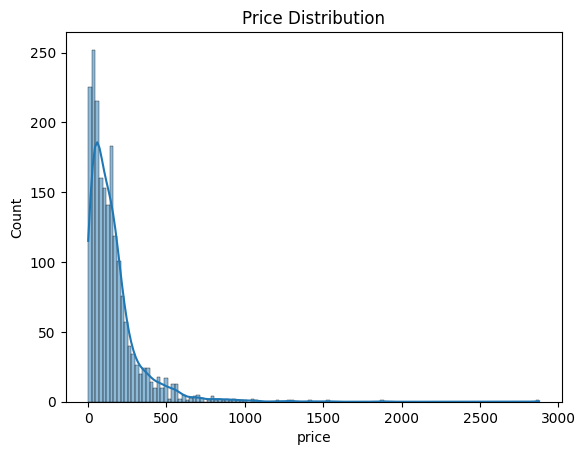

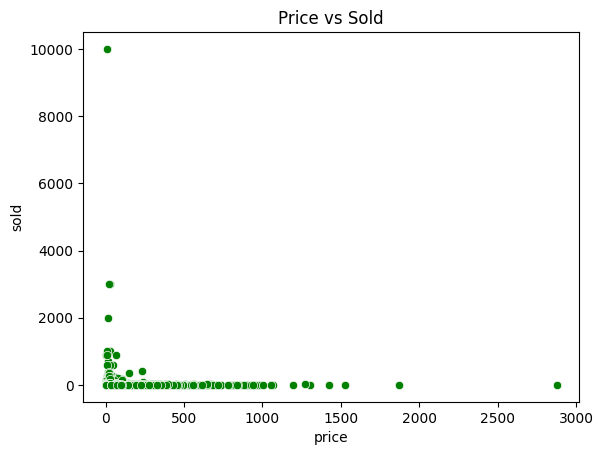

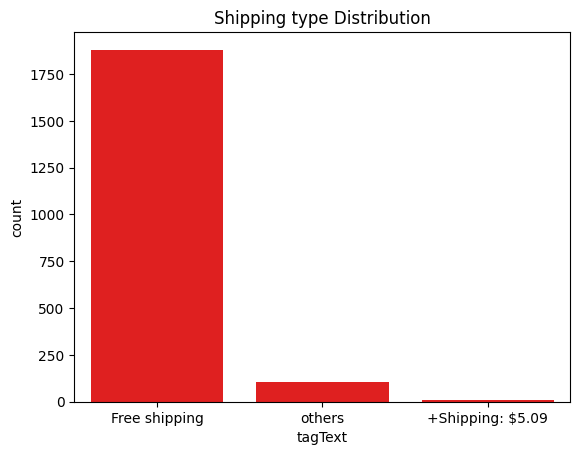

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Price
sns.histplot(df['price'],kde=True)
plt.title('Price Distribution')
plt.show()

# Scatter plot Price vs sold
sns.scatterplot(data=df,x='price',y='sold',color='g')
plt.title('Price vs Sold')
plt.show()

# Countplot tagText
sns.countplot(data=df,x = 'tagText', color = 'r')
plt.title('Shipping type Distribution')
plt.show()

# **Step 4: Feature Engineering**

- Encode tagText
- TF-IDF on productTitle
-Merging with original DataFrame

In [38]:
from sklearn.preprocessing import LabelEncoder         # LabelEncoder: Converts textual data into numerical data
from sklearn.feature_extraction.text import TfidfVectorizer    # TfidfVectorizer converts texts (like productTitle) into matrix of numerical values
le = LabelEncoder()
# Converting textual data into numerical data (eg: 1,2,3,...)
df['tagText'] = le.fit_transform(df['tagText'])

# Filling null productTitle (if any) with an empty string [it is necessary for text processing TF-IDF ]
df['productTitle'] = df['productTitle'].fillna('')

# TF-IDF on productTitle
tfidf = TfidfVectorizer(max_features=20)            # Keeps only top 20 important words and create new columns for each
title_tfidf = tfidf.fit_transform(df['productTitle'])       # TF-IDF transformations on all values in 'productTitle'

# Merging with original DataFrame
title_tfidf_df = pd.DataFrame(title_tfidf.toarray(),columns=tfidf.get_feature_names_out())   # converting matrix into a DataFrame to merge
df = pd.concat([df.reset_index(drop=True),title_tfidf_df],axis = 1)

# Drop the original 'productTitle' column
df.drop('productTitle',axis = 1,inplace=True)

# **Step 5: Model Training**
- Predict sold (target) using features
- Use two models: Linear Regression & Random Forest

In [43]:
# If sold is mostly 0 and a few high values
df['sold_class'] = df['sold'].apply(lambda x: 1 if x > 0 else 0)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = df.drop('sold',axis = 1)                  # Creating feature matrix x and dropping 'sold' column (Stores only independent variables)
y = df['sold']                                # Y Stores the target variable (number of units sold) (dependent variable)

# Splitting the dataset into two parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)     #  20% for testing and 80% for training and maintaining the same random split each time

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=42)

lr.fit(X_train, y_train)                                  # training linear regression model with the training data
rf.fit(X_train, y_train)                                  # training RandomForest model using the training data

RandomForestRegressor(max_depth=10, random_state=42)

# **Step 6: Model Evaluation**
- Compare both models with MSE and R² Score

In [45]:
from sklearn.metrics import mean_squared_error, r2_score         # mse - checks how far predictions are from actual values
y_pred_lr = lr.predict(X_test)                                   # Using trained linear Regression model to predict the X_test
y_pred_rf = rf.predict(X_test)                                   # Using the trained RandomForest model to predict the sold values for same test data as above

print('\nLinear Regression:')
print('MSE:',mean_squared_error(y_test,y_pred_lr))
print('R2 Score:',r2_score(y_test,y_pred_lr))

print("\nRandom Forest:")
print('MSE:',mean_squared_error(y_test,y_pred_rf))
print('R2 Score:',r2_score(y_test,y_pred_rf))



Linear Regression:
MSE: 177.83127607745158
R2 Score: 0.10751649830438559

Random Forest:
MSE: 196.19900536968294
R2 Score: 0.015334202149753562
